In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
import numpy as np
import pandas as pd
import torch
import torchvision as tv
import re
import time
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Module, GRU, Embedding, Linear, Sigmoid, CrossEntropyLoss, ReLU, Tanh, Sequential
from torch import nn
from torchvision import transforms
import torch.optim as optim
from torchvision.utils import make_grid, save_image
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

In [5]:
# # clear shared RAM (Colab shares RAM and GPU with other user sessions, this guarantees all resources allocated to this session)
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil --quiet
# !pip install psutil --quiet
# !pip install humanize --quiet
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()
# # only one GPU on Colab and isn't guaranteed
# gpu = GPUs[0]
# proc = psutil.Process(os.getpid())
# print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " | Proc size: " + humanize.naturalsize(proc.memory_info().rss))
# print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [6]:
# learning parameters
batch_size = 512
epochs = 200
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

In [8]:
fmnist = datasets.FashionMNIST(root='./', train=True, download=True, transform=transform)
data_loader = DataLoader(fmnist, batch_size=batch_size, shuffle=True)

In [9]:
class Generator(Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = Sequential(
            Linear(self.nz, 256),
            ReLU(),

            Linear(256, 512),
            ReLU(),

            Linear(512, 784),
            Tanh(),
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)


In [10]:
# class Discriminator(Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.n_input = 784
#         self.main = Sequential(
#             Linear(self.n_input, 1024),
#             ReLU(),
#             Linear(1024, 512),
#             ReLU(),
#             Linear(512, 1),
#             nn.Sigmoid(),
#         )
#     def forward(self, x):
#         x = x.view(-1, 784)
#         return self.main(x)

Initialize the Neural Networks and Define the Optimizers

In [11]:


generator = Generator(nz).to(device)
# discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
# print('######################')
# print('\n##### DISCRIMINATOR #####')
# print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Tanh()
  )
)
######################


In [12]:
# optimizers

optim_g = optim.Adam(generator.parameters(), lr=0.0002)
# optim_d = optim.Adam(discriminator.parameters(), lr=0.001)

In [13]:
# loss function
criterion = nn.MSELoss()

In [14]:
losses_g = [] # to store generator loss after each epoch
# losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [15]:
# # to create real labels (1s)
# def label_real(size):
#     data = torch.ones(size, 1)
#     return data.to(device)
# # to create fake labels (0s)
# def label_fake(size):
#     data = torch.zeros(size, 1)
#     return data.to(device)

In [16]:
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [17]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [18]:
# # function to train the discriminator network
# def train_discriminator(optimizer, data_real, data_fake):
#     b_size = data_real.size(0)
#     real_label = label_real(b_size)
#     fake_label = label_fake(b_size)
#     optimizer.zero_grad()
#     output_real = discriminator(data_real)
#     loss_real = criterion(output_real, real_label)
#     output_fake = discriminator(data_fake)
#     loss_fake = criterion(output_fake, fake_label)
#     loss_real.backward()
#     loss_fake.backward()
#     optimizer.step()
#     return loss_real + loss_fake

In [19]:
# function to train the generator network
def train_generator(optimizer, data_fake, data_real):
    
    optimizer.zero_grad()
    loss = criterion(data_fake, data_real)
    loss.backward()
    optimizer.step()
    return loss

In [20]:
# create the noise vector
noise = create_noise(sample_size, nz)
generator.train()
# discriminator.train()

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Tanh()
  )
)

In [21]:
# path = "/content/drive/MyDrive/Deep_Learning/HW3/"
path = "./models/MSE/"
epochs = 200
# k = 10
length = 0.

for epoch in range(epochs):
    start = time.time()
    loss_g = 0.0
    # loss_d = 0.0
    # for bi, data in tqdm(enumerate(data_loader), total=int(len(fmnist)/data_loader.batch_size)):
    for bi, data in enumerate(data_loader):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake, image)
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, path + f"gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    # epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    # losses_d.append(epoch_loss_d)
    prev = -9999
    # print(f"")
    end = time.time() - start
    length += end
    mean_so_far = length / (epoch+1)
    time_left = (mean_so_far * (epochs - epoch - 1))/60
    
    print(f"Epoch {epoch} of {epochs}:\t\t{end:.2f} seconds;\ttotal: {length:.2f};\tminutes left: {time_left:.2f}")
    print(f"Generator loss: {epoch_loss_g:.8f}")
    prev = epoch_loss_g

Epoch 0 of 200:		13.77 seconds;	total: 13.77;	minutes left: 45.68
Generator loss: 0.40348732
Epoch 1 of 200:		13.46 seconds;	total: 27.23;	minutes left: 44.93
Generator loss: 0.35494575
Epoch 2 of 200:		13.19 seconds;	total: 40.42;	minutes left: 44.24
Generator loss: 0.35395530
Epoch 3 of 200:		13.36 seconds;	total: 53.79;	minutes left: 43.93
Generator loss: 0.35332060
Epoch 4 of 200:		13.09 seconds;	total: 66.88;	minutes left: 43.47
Generator loss: 0.35300583
Epoch 5 of 200:		13.08 seconds;	total: 79.96;	minutes left: 43.09
Generator loss: 0.35295978
Epoch 6 of 200:		13.85 seconds;	total: 93.81;	minutes left: 43.11
Generator loss: 0.35271084
Epoch 7 of 200:		13.64 seconds;	total: 107.45;	minutes left: 42.98
Generator loss: 0.35268250
Epoch 8 of 200:		13.37 seconds;	total: 120.82;	minutes left: 42.74
Generator loss: 0.35241479
Epoch 9 of 200:		13.72 seconds;	total: 134.54;	minutes left: 42.60
Generator loss: 0.35211721
Epoch 10 of 200:		14.54 seconds;	total: 149.08;	minutes left: 42.69

In [22]:
print('DONE TRAINING')
torch.save(generator.state_dict(), path + 'generator.pth')
path

DONE TRAINING


'./models/MSE/'

In [23]:
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave(path + 'generator_images.gif', imgs)

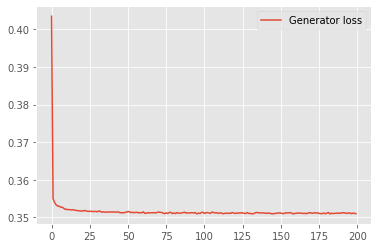

In [24]:
plt.figure()
plt.plot([x.detach() for x in losses_g], label='Generator loss')
# plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig(path + 'loss.png')